**Deep Learning 2023/24 - Final Project**
===============

Prediction of Stock Prices
---------------

## Team:
- Lukas Weigmann
- Andre Datchev
- Hannes Pohnke

-----------------------------------

Outline
1. Preface/Intro/benchmark
2. Dataset
3. Data preparation
4. model 1
5. model 2 
6. model ...
7. Evaluation
8. Conclusion

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

#import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM
from pandas_datareader import data as pdr
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


## *1. Introduction*

## *Acquiring data*

----------------------------------

We will use yfinance to load the price histories of the Stocks we want to have.

/Users/lukasweigmann/miniconda3/envs/FinancialForecasting/lib/python3.9/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed


                Open      High       Low     Close  Adj Close  Volume
Date                                                                 
2018-02-06  293150.0  303431.0  288540.0  303000.0   303000.0    1200
2018-02-07  304200.0  306710.0  301000.0  301000.0   301000.0     500
2018-02-08  301190.0  301190.0  288000.0  288000.0   288000.0     600
2018-02-09  293859.0  296296.0  285250.0  294140.0   294140.0     900
2018-02-12  298100.0  301020.0  295000.0  298940.0   298940.0     400 
 (1509, 6) 

            Adj Close
Date                 
2018-02-06   303000.0
2018-02-07   301000.0
2018-02-08   288000.0
2018-02-09   294140.0
2018-02-12   298940.0


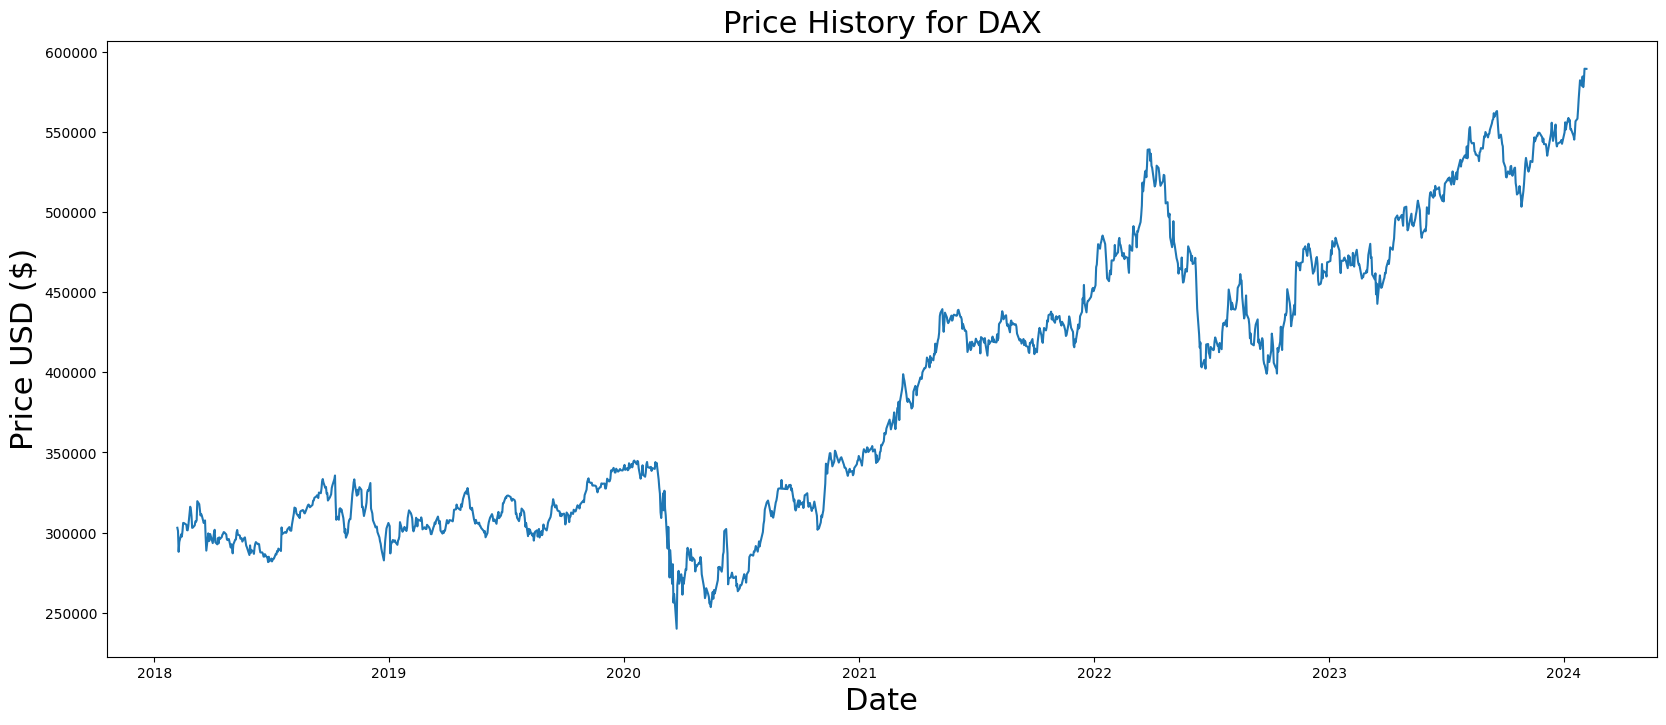

In [7]:
yf.pdr_override()
pd.set_option('display.max_rows', None)

#timeframe we want to load the data from in years
timeframe = 6

#setting end and start date 
end = datetime.now()
    #end = datetime(end .year - 1, end.month, end.day)
start = datetime(end.year - timeframe, end.month, end.day)

#how the downloaded dataframe looks
dax = pdr.get_data_yahoo("BRK-A", start, end)
print(dax.head(), "\n", dax.shape, "\n")

#extracting the price history
dax_history = dax.filter(["Adj Close"])
print(dax_history.head())
#interpolating the missing Values

#visulazing
def plot_history(history, index):
    plt.figure(figsize=(20,8))
    plt.title('Price History for ' + index, fontsize=22)
    plt.plot(history)
    plt.xlabel('Date', fontsize=22)
    plt.ylabel('Price USD ($)', fontsize=22)

    plt.show()
    
plot_history(dax_history, "DAX")


In [128]:
# stock_data = PyTickerSymbols()
# 
# # Tickers for current dax companies
# # ! We'll only use current DAX companies (the size composition of the index changes through time)
# 
# dax_overview = stock_data.get_stocks_by_index('DAX') # this includes additional data like industry, number of employees but not super useful ig
# dax_tickers = [entry['symbol'] for entry in dax_overview]
# dax_tickers = [f"{ticker}.F" for ticker in dax_tickers] # F for Frankfurt tickers
# print(dax_tickers)
# 
# if 'DPW.F' in dax_tickers: 
#     dax_tickers[dax_tickers.index('DPW.F')] = 'DPWA.F' # seemingly PyTickerSymbols() doesnt know of this name change yet 


In [129]:
#loading more data
def load_histories(indices):
    stock_histories = []
    for index in indices :
        stock = pdr.get_data_yahoo(index, start, end)
        adj_close_history = stock['Adj Close']
        stock_histories.append(adj_close_history)
        
    return stock_histories

stocks = ['ADS.F', 'ALV.F', 'BAS.F', 'BAYN.F', 'BEI.F', 'BMW.F', 'CON.F', 
          '1COV.F', 'DBK.F', 'DB1.F', 'DPWA.F', 'DTE.F', 'EOAN.F', 'FME.F', 
          'FRE.F', 'HEI.F', 'HEN3.F', 'IFX.F', 'LIN.F', 'MRK.F', 'MUV2.F', 
          'RWE.F', 'SAP.F', 'SIE.F', 'VOW3.F', 'VNA.F', 'AIR.F', 'BNR.F', 
          'HNR1.F', 'MTX.F', 'PUM.F', 'QIA.F', 'SRT3.F', 'SHL.F', 'SY1.F', 
          'ZAL.F', 'ENR.F', 'PAH3.F', 'DTG.F', 'MBG.F']

dax_histories = load_histories(stocks)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [130]:
#Filtering 'incomplete' histories
lengths = [len(history) for history in dax_histories]

# Count the occurrences of each length
from collections import Counter
length_counts = Counter(lengths)

# Display the unique lengths and their frequencies
for length, count in length_counts.items():
    print(f"Length {length}: {count} occurrences")

Length 1519: 33 occurrences
Length 1520: 3 occurrences
Length 1524: 1 occurrences
Length 1490: 1 occurrences
Length 852: 1 occurrences
Length 545: 1 occurrences


In [131]:
filtered_histories = [history for history in dax_histories if len(history) == 763]

# Convert to NumPy array for model to use
stock_array = np.array(filtered_histories)

## *3. Data Preparation*

---------------------------------

- normalize
- train test split
- transform
- ...

### 1. Prediction of tomorrows price

In [9]:
#Feature Scaling
dataset = dax_history.values

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_dataset = scaler.fit_transform(dataset)
print(scaled_dataset[:5])

[[0.18025854]
 [0.17453605]
 [0.13733984]
 [0.1549079 ]
 [0.16864188]]


In [139]:
#lookback window for prediction:
lag = 60

#train test split:
ratio = 0.8

train_data_len = int(np.ceil( len(dataset) * ratio ))

train_data, test_data = scaled_dataset[:train_data_len, :], scaled_dataset[train_data_len - lag:]

#print(train_data[training_data_len - 10:], "\n\n", test_data[:10])
print(len(dataset), "=", len(train_data), "+", len(test_data), "+", lag)

1509 = 1208 + 361 + 60


In [162]:
# Data transformation: We will create datasamples with a corresponding label from our linear history. 
# Each sample will be 60 consecutive Values and the label y will be the price for the day after.

def create_samples(sequential_data, lag=60):
    x, y = [], []
    
    for i in range(lag, len(sequential_data)):
        x.append(train_data[i-lag:i, 0])
        y.append(train_data[i, 0])
    return np.array(x), np.array(y)

train_X, train_Y = create_samples(train_data, lag)
#print(train_X.shape)
#print(train_Y.shape)


test_X, _ = create_samples(test_data, lag)

train_X

array([[0.15908532, 0.18025854, 0.17453605, ..., 0.16021551, 0.14492215,
        0.15087354],
       [0.18025854, 0.17453605, 0.13733984, ..., 0.14492215, 0.15087354,
        0.1443499 ],
       [0.17453605, 0.13733984, 0.1549079 , ..., 0.15087354, 0.1443499 ,
        0.13462452],
       ...,
       [0.56003182, 0.5785727 , 0.59513931, ..., 0.65535997, 0.6483585 ,
        0.65303092],
       [0.5785727 , 0.59513931, 0.56137946, ..., 0.6483585 , 0.65303092,
        0.64526836],
       [0.59513931, 0.56137946, 0.55307899, ..., 0.65303092, 0.64526836,
        0.64004658]])

### 2. Classification in 5 categories

(1509, 1)


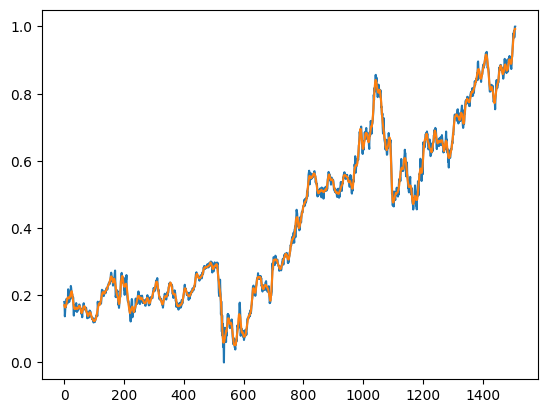

In [37]:
# Smoothing the curve with moving average
from scipy.signal import savgol_filter

plt.plot(scaled_dataset)

print(scaled_dataset.shape)

smoothed_dataset = savgol_filter(scaled_dataset[:,0], window_length=15, polyorder=3)

plt.plot(smoothed_dataset)


# Our Model



In [163]:
#initializing model
model = Sequential()
model.add(LSTM(4, input_shape= (lag, 1)))
#model.add(LSTM(128, return_sequences=True, input_shape= (lag, 1)))
#model.add(LSTM(64, return_sequences=True))
#model.add(LSTM(32, return_sequences=False))
#model.add(Dense(16))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

In [164]:
#training
model.fit(train_X, train_Y, batch_size=1, epochs=1)

1148/1148 [==============================] - 7s 5ms/step - loss: 0.0284


In [165]:
#making predictions
predictions = model.predict(test_X)
predictions = scaler.inverse_transform(predictions)

print(dataset[train_data_len:train_data_len + 10])
predictions[:10]

10/10 [==============================] - 0s 2ms/step
[[468922.]
 [476980.]
 [477020.]
 [478676.]
 [472712.]
 [475843.]
 [480280.]
 [477085.]
 [477403.]
 [468700.]]


array([[303308.72],
       [303029.88],
       [302626.22],
       [302488.94],
       [302483.  ],
       [302476.03],
       [302654.22],
       [302893.3 ],
       [302996.16],
       [303078.22]], dtype=float32)

<class 'pandas.core.frame.DataFrame'>


C:\Users\hajap\AppData\Local\Temp\ipykernel_20092\1437725102.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['predictions'] = preds


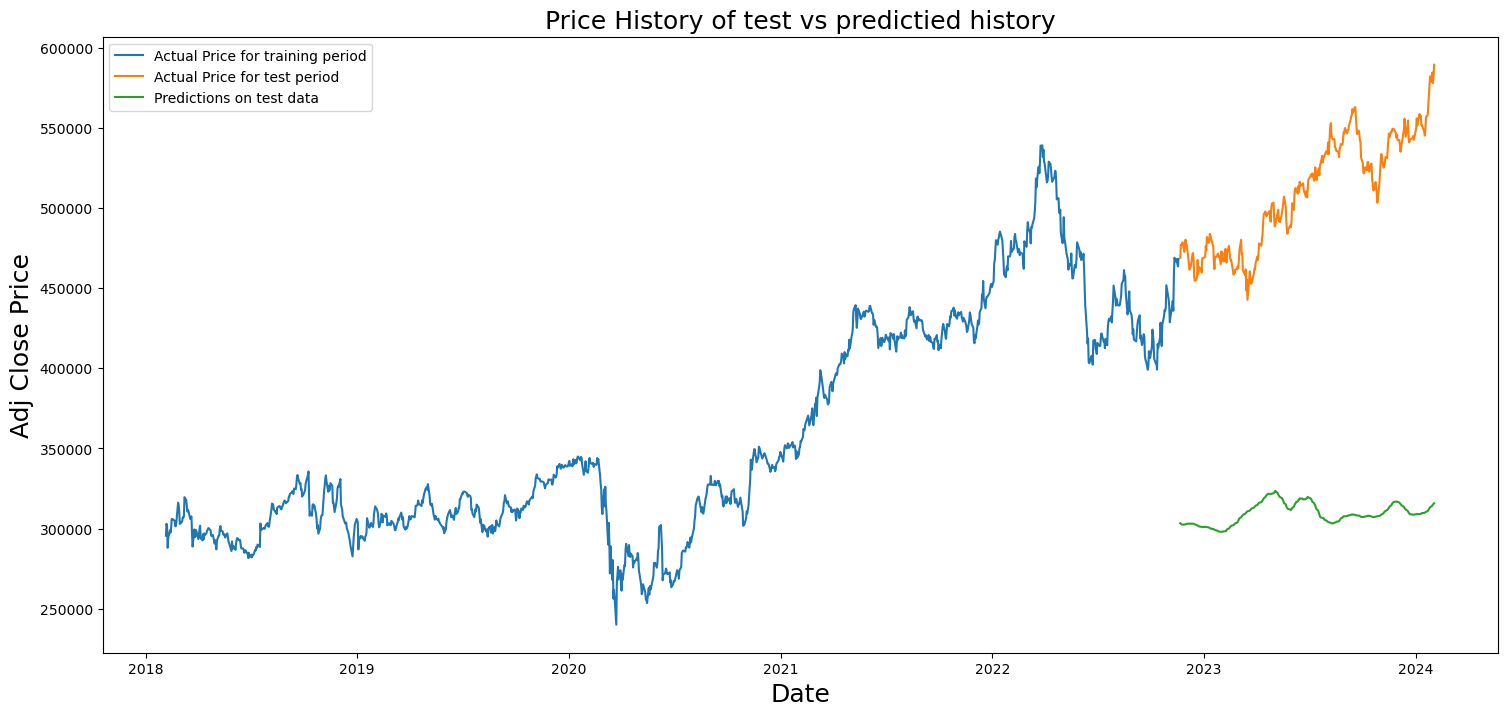

In [166]:
mse_model1 = mean_squared_error(predictions, test_Y)
rmse_model1 = np.sqrt(mse_model1)

#visualize Results
def plot_results(stock, train, test, preds):
    test['predictions'] = preds
    
    plt.figure(figsize=(18,8))
    plt.plot(train)
    plt.plot(test)
    plt.title(f"Price History of {stock} vs predictied history", fontsize=18)
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Adj Close Price', fontsize=18)
    plt.legend(['Actual Price for training period', 'Actual Price for test period', 'Predictions on test data'])
    
    plt.show()
    

print(type(dax_history))
train_history = dax_history[:train_data_len]
test_history = dax_history[train_data_len:]
plot_results("test", train_history, test_history, predictions)